# Emotion-Recognition Kaggle Model V14

I will try a different iteration of v6 since it was the best by now, and try to add more hidden layers and see how the model performs.

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input
from sklearn.metrics import confusion_matrix
import random
import glob
import itertools
import os
import shutil
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Process the data
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define sets
# Since the tesing set has more data than the created validate, we will use test as validate and validate as test
training_path = '../../../datasets/kaggle_dataset_train/'
valididation_path = '../../../datasets/kaggle_dataset_test/'
testing_path = '../../../datasets/kaggle_dataset_validate/'

Num GPUs Available:  1


In [3]:
# Now we use Keras's ImageDataGenerator class to create batches of data from the training, validation and testing sets
train_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10, horizontal_flip=True).flow_from_directory(directory=training_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32)
valid_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10, horizontal_flip=True).flow_from_directory(directory=valididation_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(directory=testing_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32, shuffle=False)

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2867 images belonging to 7 classes.


In [4]:
# I will try something a more complex now
model = Sequential()

# Convolutional Layer N.1
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Convolutional Layer N.2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Convolutional Layer N.3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# Convolutional Layer N.4
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Convolutional Layer N.5
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))

# Convolutional Layer N.6
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.5
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))


# Now we flatten the volume to pass it to the fully connected layers
model.add(Flatten())

# Now we create the first fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.1))

# Now we create the second fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.1))

# Now we create the output [7 is the number of classes]
# We use softmax since it's for multi-classification
model.add(Dense(7, activation="softmax"))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        2

The model itself is very simple, we have an input layer that takes images images that are 48 by 48 with only 1 channel (grayscale), the we have 2 hidden layers each followed by maxpooling in order to reduce the dimension. We also enable zero-padding by specifying padding = 'same'.
The output layer has 7 outputs each for each emotion class. Again, very simple, then later I will make it more complex or maybe use as base another trained model.

In [6]:
# Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric.

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

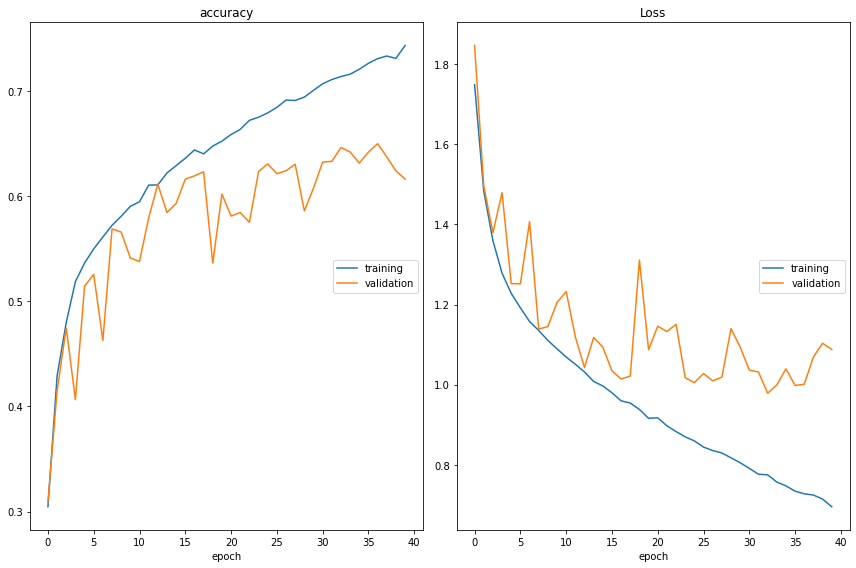

accuracy
	training         	 (min:    0.305, max:    0.743, cur:    0.743)
	validation       	 (min:    0.309, max:    0.650, cur:    0.616)
Loss
	training         	 (min:    0.695, max:    1.749, cur:    0.695)
	validation       	 (min:    0.979, max:    1.847, cur:    1.088)


In [7]:
callbacks = [PlotLossesKerasTF()]

# Now I will train the model using 
model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=40,
    callbacks=callbacks
)

Confusion matrix, without normalization
[[213   9  24  16  52  67  18]
 [ 12  21   1   1   0   7   1]
 [ 43   0 132  11  61  88  74]
 [ 18   0  16 563  64  35  25]
 [ 35   1  16  21 318  88  17]
 [ 38   4  28  10  96 293  14]
 [  8   0  12  17  13   2 264]]


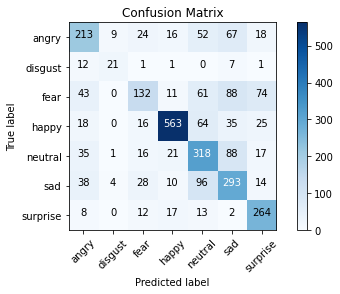

In [8]:
#Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, we'll plot them in a confusion matrix

test_imgs, test_labels = next(test_batches)
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [9]:
# I will save anyways the model for the archive
model.save("kaggle_model_v14.h5")

# serialize the model to json
model_json = model.to_json()
# save the model architecture to JSON file
with open("kaggle_model_v14.json", "w") as json_file:
    json_file.write(model_json)

model_yaml = model.to_yaml()
with open("kaggle_model_v14.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# Convert model to TensorFlowJS
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'tensorflowJS')